# Bidirectional LSTM + CRF
- https://wikidocs.net/34156
- CRF(Conditional Random Field)라는 새로운 층을 추가

## Import

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [ ]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [1]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [37]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

Using TensorFlow backend.


## load dataset

In [5]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
print(data.shape)
data[:5]

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [10]:
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [11]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 47959
Word 열의 중복을 제거한 값의 개수 : 35178
Tag 열의 중복을 제거한 값의 개수 : 17


In [12]:
print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


## preprocessing

In [13]:
# Pandas의 (method='ffill')는 Null 값을 가진 행의 바로 앞의 행의 값으로 Null 값을 채우는 작업
data = data.fillna(method="ffill")
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [14]:
data.isnull().any()

Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool

In [19]:
data["Word"] = data["Word"].str.lower()
print(f"Num of unique words: {len(data.Word.unique())}")

Num of unique words: 31817


In [21]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values, temp["Tag"].values)]
tagged_sentences = [t for t in data.groupby("Sentence #").apply(func)]
print(f"Num of samples: {len(tagged_sentences)}")

Num of samples: 47959


In [22]:
tagged_sentences[0]

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [26]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))
len(sentences), len(ner_tags)

(47959, 47959)

샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


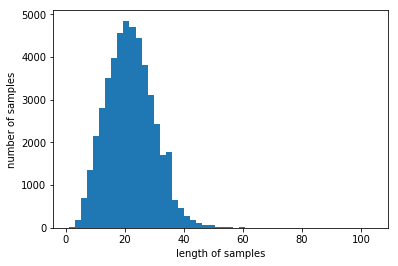

In [24]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### integer encodding

In [27]:
src_tokenizer = Tokenizer(oov_token="OOV") # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [28]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
vocab_size, tag_size

(31819, 18)

In [30]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)
len(x_train), len(y_train)

(47959, 47959)

In [31]:
x_train[0], y_train[0]

([254,
  6,
  967,
  16,
  1795,
  238,
  468,
  7,
  523,
  2,
  129,
  5,
  61,
  9,
  571,
  2,
  833,
  6,
  186,
  90,
  22,
  15,
  56,
  3],
 [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1])

In [33]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word
index_to_ner[0]='PAD'
index_to_ner

{1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'B-eve',
 13: 'I-art',
 14: 'I-eve',
 15: 'B-nat',
 16: 'I-gpe',
 17: 'I-nat',
 0: 'PAD'}

### padding

In [34]:
max_len = 70
x_train = pad_sequences(x_train, padding="post", maxlen=max_len)
y_train = pad_sequences(y_train, padding="post", maxlen=max_len)
x_train.shape, y_train.shape

((47959, 70), (47959, 70))

### split train, test set

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38367, 70), (9592, 70), (38367, 70), (9592, 70))

### to categorical

In [36]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)
y_train.shape, y_test.shape

((38367, 70, 18), (9592, 70, 18))

## Train LSTM+CRF

In [71]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=20, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 20)            636380    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 100)           28400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 70, 18)            1278      
Total params: 671,108
Trainable params: 671,108
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

/Users/user/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/user/anaconda3/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [73]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=32, 
    epochs=5, 
    validation_split=0.1, 
    verbose=1
)

Train on 34530 samples, validate on 3837 samples
Epoch 1/5
34530/34530 [==============================] - 142s 4ms/step - loss: 8.3946 - crf_viterbi_accuracy: 0.8887 - val_loss: 8.1799 - val_crf_viterbi_accuracy: 0.9324
Epoch 2/5
34530/34530 [==============================] - 186s 5ms/step - loss: 8.1383 - crf_viterbi_accuracy: 0.9460 - val_loss: 8.1045 - val_crf_viterbi_accuracy: 0.9510
Epoch 3/5
34530/34530 [==============================] - 187s 5ms/step - loss: 8.0977 - crf_viterbi_accuracy: 0.9563 - val_loss: 8.1036 - val_crf_viterbi_accuracy: 0.9459
Epoch 4/5
34530/34530 [==============================] - 186s 5ms/step - loss: 8.0832 - crf_viterbi_accuracy: 0.9602 - val_loss: 8.0811 - val_crf_viterbi_accuracy: 0.9567
Epoch 5/5
34530/34530 [==============================] - 227s 7ms/step - loss: 8.0749 - crf_viterbi_accuracy: 0.9633 - val_loss: 8.0760 - val_crf_viterbi_accuracy: 0.9566


## Evaluate

In [74]:
print(f"Accuracy: {model.evaluate(x_test, y_test, verbose=2)[1]}")

Accuracy: 0.9576188841395025


In [75]:
i=13
y_predicted = model.predict(np.array([x_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(x_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O


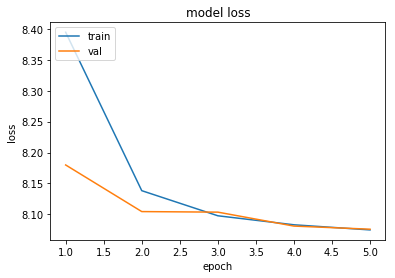

In [76]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 시퀀스 레이블링 평가하기

In [77]:
# !pip install seqeval

In [78]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [79]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true)

hit = 0 # 정답 개수
for t, p in zip(true, predicted):
    if t == p:
        hit +=1 # 정답인 경우에만 +1
accuracy = hit/len(true) # 정답 개수를 총 개수로 나눈다.
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [80]:
print(classification_report(true, predicted))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



### Calculate f1-score

In [81]:
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace("PAD", "0"))
        result.append(temp)
    return result

In [82]:
y_predicted = model.predict(x_test)
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)
len(pred_tags), len(test_tags)

(9592, 9592)

In [83]:
print(classification_report(test_tags, pred_tags))

/Users/user/anaconda3/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:42: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.20      0.02      0.04        52
         geo       0.85      0.84      0.84      7620
         gpe       0.97      0.93      0.95      3145
         nat       0.00      0.00      0.00        37
         org       0.64      0.54      0.59      4033
         per       0.80      0.73      0.76      3545
         tim       0.87      0.83      0.85      4067

   micro avg       0.83      0.77      0.80     22562
   macro avg       0.54      0.49      0.50     22562
weighted avg       0.82      0.77      0.79     22562



In [84]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 80.0%


## 새로운 입력에 대해서 예측하기

In [85]:
word_to_index = src_tokenizer.word_index
len(word_to_index)

31818

In [86]:
new_sentence='Hong Gildong starts over with the Justice League of Joseon at the country of Yul'.split()
new_sentence

['Hong',
 'Gildong',
 'starts',
 'over',
 'with',
 'the',
 'Justice',
 'League',
 'of',
 'Joseon',
 'at',
 'the',
 'country',
 'of',
 'Yul']

In [87]:
new_x = [word_to_index.get(w,1) if w in word_to_index else word_to_index['OOV'] for w in new_sentence]
new_x

[1, 1, 4027, 80, 17, 2, 1, 1, 6, 1, 20, 2, 56, 6, 1]

In [88]:
pad_new = pad_sequences([new_x], padding="post", value=0, maxlen=max_len)
pad_new.shape

(1, 70)

In [89]:
p = model.predict(np.array([pad_new[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("단어", "예측값"))
print(30 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:15}: {:5}".format(w, index_to_ner[pred]))

단어             ||예측값
Hong           : B-per
Gildong        : I-per
starts         : O    
over           : O    
with           : O    
the            : O    
Justice        : B-org
League         : I-org
of             : I-org
Joseon         : I-org
at             : O    
the            : O    
country        : O    
of             : O    
Yul            : B-geo
